In [1]:
import torch
import torch.nn as nn
import torchvision
from datasets.SSL4EO.ssl4eo_dataset_lmdb_mm import LMDBDataset
from cvtorchvision import cvtransforms
import numpy as np
import matplotlib.pyplot as plt

/p/project/hai_dm4eo/wang36/jupyter/kernels/wang36_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, season='fixed'):
        self.base_transform = base_transform
        self.season = season

    def __call__(self, x):

        if self.season=='augment':
            season1 = np.random.choice([0,1,2,3])
            season2 = np.random.choice([0,1,2,3])
        elif self.season=='fixed':
            np.random.seed(42)
            season1 = np.random.choice([0,1,2,3])
            season2 = season1
        elif self.season=='random':
            season1 = np.random.choice([0,1,2,3])
            season2 = season1

        x1 = np.transpose(x[season1,:,:,:],(1,2,0))
        #x2 = np.transpose(x[season2,:,:,:],(1,2,0))

        q = self.base_transform(x1)
        #k = self.base_transform(x2)

        #return [q, k]
        return q

In [3]:
data1 = '/p/project/hai_dm4eo/wang_yi/data/251k_sar.lmdb'
data2 = '/p/project/hai_dm4eo/wang_yi/data/251k_ms.lmdb'
season = 'fixed'

In [9]:
from models.rs_transforms_uint8 import RandomChannelDrop,RandomBrightness,RandomContrast,ToGray

train_transforms_s1 = cvtransforms.Compose([
    #cvtransforms.Resize(128),
    cvtransforms.CenterCrop(224),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(2)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_transforms_s2c = cvtransforms.Compose([
    #cvtransforms.Resize(128),
    cvtransforms.CenterCrop(224),
    #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    #cvtransforms.RandomApply([
    #    RandomBrightness(0.4),
    #    RandomContrast(0.4)
    #], p=0.8),
    #cvtransforms.RandomApply([ToGray(13)], p=0.2),
    #cvtransforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    #cvtransforms.RandomHorizontalFlip(),       
    cvtransforms.ToTensor()
    #cvtransforms.RandomApply([RandomChannelDrop(min_n_drop=1, max_n_drop=6)], p=0.5),        
    ])


train_dataset = LMDBDataset(
    lmdb_file_s1=data1,
    lmdb_file_s2=data2,
    s1_transform= TwoCropsTransform(train_transforms_s1,season=season),
    s2c_transform=TwoCropsTransform(train_transforms_s2c,season=season),
    is_slurm_job=True,
    normalize=False,
    dtype1='float32',
    dtype2='uint8',
    mode=['s1','s2c']
)   


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=False,
    num_workers=0, drop_last=True)

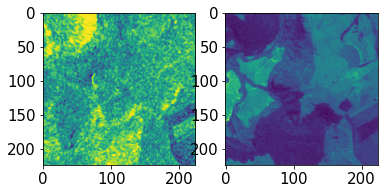

In [10]:
## visualize
img_sar = train_dataset[10][0]
img_ms = train_dataset[10][1]
plt.subplot(1,2,1)
plt.imshow(img_sar[0])
plt.subplot(1,2,2)
plt.imshow(img_ms[1])

In [11]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class BarlowTwins(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone_1 = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone_2 = torchvision.models.resnet50(zero_init_residual=True)

        self.backbone_1.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)            
        self.backbone_2.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.backbone_1.fc = nn.Identity()
        self.backbone_2.fc = nn.Identity()

        
        # projector
        sizes = [2048] + list(map(int, '512-512-512'.split('-')))

        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector1 = nn.Sequential(*layers)
        self.projector2 = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2        
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)
        
        #self.bn = nn.BatchNorm1d(2048, affine=False)

    def forward(self, y1, y2):
        z1 = self.projector1(self.backbone_1(y1))
        z2 = self.projector2(self.backbone_2(y2))
        #z1 = self.backbone_1(y1)
        #z2 = self.backbone_2(y2)        

        # empirical cross-correlation matrix
        c = self.bn(z1).T @ self.bn(z2)

        # sum the cross-correlation matrix between all gpus
        c.div_(64)
        #torch.distributed.all_reduce(c)

        #on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        #off_diag = off_diagonal(c).pow_(2).sum()
        #loss = on_diag + self.args.lambd * off_diag
        #return loss,on_diag,off_diag
        return c,z1,z2

In [12]:
resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_p2/B2B13_bt_rn50/checkpoint_0099.pth'
#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_rn50/checkpoint_0099.pth'
resume1 = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_decu_rn50/checkpoint_0099.pth'

#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_p2/B2B13_bt_rn50/checkpoint_0099.pth'
#resume1 = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/late_fusion_2p2/B2B13_bt_decu_rn50_prj8192/checkpoint_0099.pth'

#resume = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/feature/B2B13_bt_rn50/checkpoint_0063.pth'
#resume1 = '/p/project/hai_dm4eo/wang_yi/ssl4eo-mm-v3/src/pretrain/checkpoints/feature/B2B13_bt_mm2_decu_rn50/checkpoint_0099.pth'

model = BarlowTwins()
#model.cuda()
ckpt = torch.load(resume, map_location='cpu')
state_dict = ckpt['model']
state_dict = {k.replace("module.", ""): v for k,v in state_dict.items()}
model.load_state_dict(state_dict)

model1 = BarlowTwins()
#model.cuda()
ckpt1 = torch.load(resume1, map_location='cpu')
state_dict1 = ckpt1['model']
state_dict1 = {k.replace("module.", ""): v for k,v in state_dict1.items()}
model1.load_state_dict(state_dict1)

<All keys matched successfully>

<Figure size 360x360 with 0 Axes>

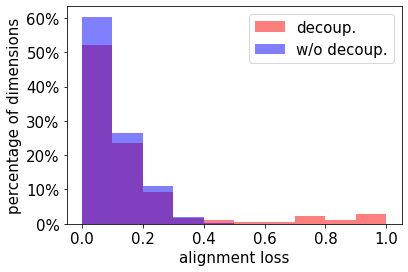

In [44]:
####### histogram of alignment loss
id = 20
model.eval()
model1.eval()
plt.figure(figsize=(5,5))
with torch.no_grad():
    for i,data in enumerate(train_loader):
        if i<id:
            continue
        if i>id:
            break
        c,_,_ = model.forward(data[0], data[1])
        c1,_,_ = model1.forward(data[0], data[1])
        on_diag = torch.diagonal(c).add_(-1).pow_(2)
        on_diag1 = torch.diagonal(c1).add_(-1).pow_(2)

from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(6,4))
plt.rcParams["font.size"] = "15"
out1 = plt.hist(on_diag1.numpy(),bins=10,range=(0,1),weights=np.ones(len(on_diag1)) / len(on_diag1), alpha=0.5, label='decoup.', color='r')
out = plt.hist(on_diag.numpy(),bins=10,range=(0,1),weights=np.ones(len(on_diag)) / len(on_diag), alpha=0.5, label='w/o decoup.', color='b')
ax = plt.gca()
#ax.set_ylim([0, 250])
ax.set_xlabel('alignment loss')
ax.set_ylabel('percentage of dimensions')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1,decimals=0))
plt.savefig('../../results/appendix/align_BE_batch_{}.pdf'.format(id),bbox_inches="tight")

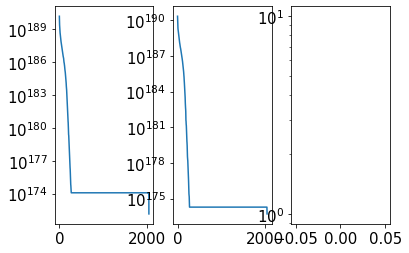

In [13]:
####### dimenional collapse?
model.eval()
#plt.figure(figsize=(5,5))
with torch.no_grad():
    for i,data in enumerate(train_loader):
        if i<1:
            continue
        if i>1:
            break
        c, z1, z2 = model.forward(data[0], data[1])
        ## correlation matrix s1s2
plt.subplot(1,3,1)
m_cov1 = np.cov(z1.numpy(),rowvar=False)
U1, D1, VT1 = np.linalg.svd(m_cov1)
plt.yscale("log")
plt.plot(D1)

plt.subplot(1,3,2)
m_cov2 = np.cov(z2.numpy(),rowvar=False)
U2, D2, VT2 = np.linalg.svd(m_cov2)
plt.yscale("log")
plt.plot(D2)

plt.subplot(1,3,3)
U, D, VT = np.linalg.svd(c)
plt.yscale("log")
plt.plot(D)